In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import OrderedDict
from scipy.ndimage import gaussian_filter1d

## Height growth curve

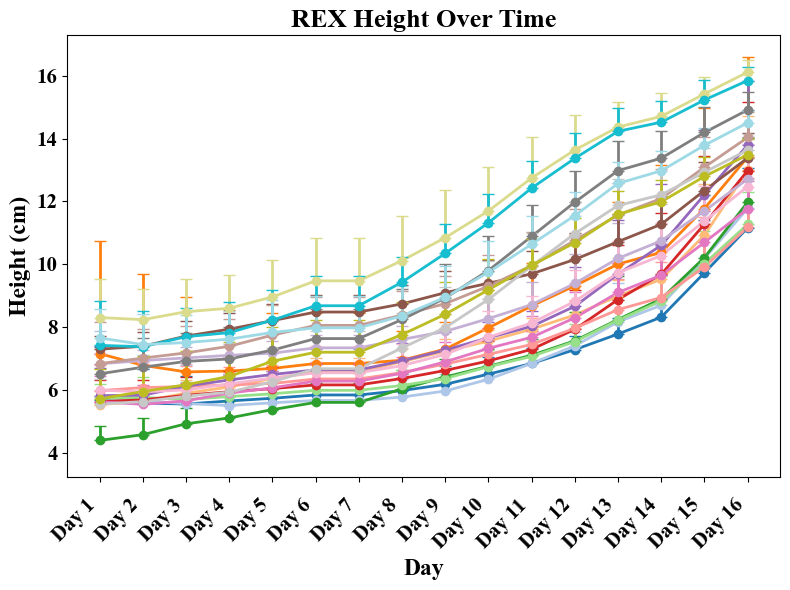

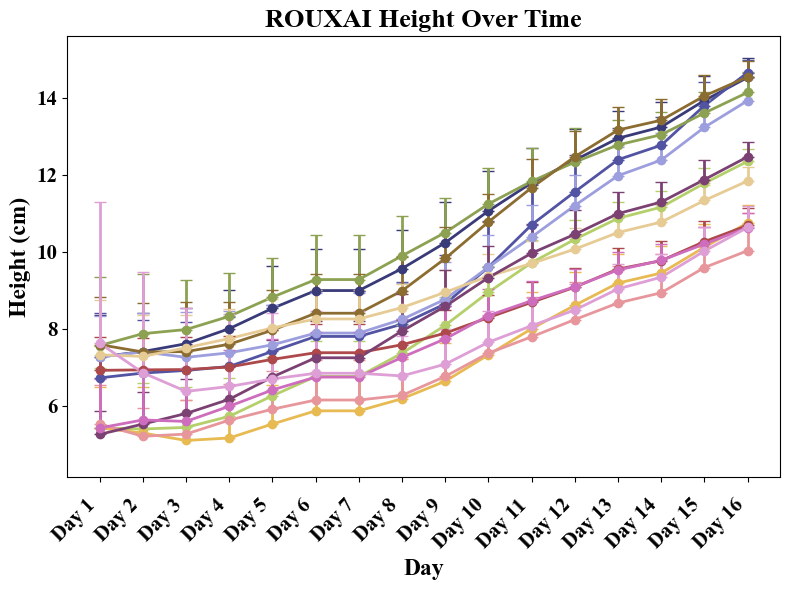

In [78]:
# Set global font family and base size for consistency
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 10 

# Load the dataset
data_height = pd.read_csv('/height_df.csv') # Replace with your file path
data_height['timestamp'] = data_height['timestamp'].str.replace('_', ':')
data_height['timestamp'] = pd.to_datetime(data_height['timestamp'], format='%Y-%m-%d %H:%M:%S')

# Identify height columns
height_columns = [col for col in data_height.columns if col.startswith('height_')]

def clean(data_column, alpha=0.1):
    return data_column.ewm(alpha=alpha, adjust=False).mean()

alpha = 0.1
df_height = pd.DataFrame({'timestamp': data_height['timestamp']})

for col in height_columns:
    if col in data_height.columns:  # Ensure column exists
        df_height[col] = clean(data_height[col], alpha=alpha)

# Set the timestamp as the index
df_height.set_index('timestamp', inplace=True)

# Get a list of all sample columns
sample_columns = [col for col in df_height.columns if col.startswith('height_')]
sample_columns = [col for col in sample_columns if col not in ['height_0', 'height_19', 'height_4', 'height_28', 'height_36',  'height_27',  'height_34']]

# Split the sample columns into two groups of 20 columns each
columns_group1 = sample_columns[:20]
columns_group2 = sample_columns[20:40]

# ============================
# Plotting Function
# ============================

def process_and_plot(ax, columns_group, group_name, cmap_name='tab20'):
    cmap = plt.get_cmap(cmap_name, len(columns_group))
    colors = [cmap(i) for i in range(len(columns_group))]
    all_means = []

    for idx, sample_column in enumerate(columns_group):
        color = colors[idx]
        lower_bound = df_height[sample_column].quantile(0.01)
        upper_bound = df_height[sample_column].quantile(0.99)
        filtered_df = df_height[(df_height[sample_column] >= lower_bound) & (df_height[sample_column] <= upper_bound)]
        daily_mean = filtered_df[sample_column].resample('D').mean()
        daily_max = filtered_df[sample_column].resample('D').max()
        rolling_mean = daily_mean.rolling(window=7, min_periods=1).mean()
        rolling_max = daily_max.rolling(window=7, min_periods=1).mean()
        rolling_max_clipped = np.minimum(rolling_max, rolling_mean * 1.5)
        error_up = rolling_max_clipped - rolling_mean
        all_means.extend(rolling_mean.values)
        day_number = np.arange(1, len(rolling_mean) + 1)

        ax.plot(day_number, rolling_mean.values, label=f'{sample_column} Mean', color=color, linewidth=2)
        ax.errorbar(
            day_number, 
            rolling_mean.values,
            yerr=[np.zeros_like(error_up.values), error_up.values],
            fmt='o', 
            ecolor=color, 
            elinewidth=2, 
            capsize=4, 
            alpha=1, 
            color=color
        )

    min_mean = np.min(all_means)
    max_mean = np.max(all_means)
    y_range = max_mean - min_mean
    padding = y_range * 0.1 
    ax.set_ylim(min_mean - padding, max_mean + padding)
    ax.set_xlabel('Day', fontsize=17, fontweight='bold')
    ax.set_ylabel('Height (cm)', fontsize=17, fontweight='bold')
    ax.set_title(f'{group_name}', fontsize=19, fontweight='bold')
    ax.tick_params(axis='x', which='major', labelsize=15, rotation=45, pad=10)
    ax.tick_params(axis='y', which='major', labelsize=15)
    max_day = len(day_number)
    num_ticks = 10
    tick_interval = max(1, max_day // num_ticks)
    tick_positions = list(range(1, max_day + 1, tick_interval))

    if tick_positions[-1] != max_day:
        tick_positions.append(max_day)

    ax.set_xticks(tick_positions)
    ax.set_xticklabels([f'Day {x}' for x in tick_positions], rotation=45, ha='right')

    y_tick_labels = ax.get_yticklabels()
    for label in y_tick_labels:
        label.set_fontweight('bold')

    x_tick_labels = ax.get_xticklabels()
    for label in x_tick_labels:
        label.set_fontweight('bold')

    return ax

# ============================
# Creating Plots
# ============================

def create_figure(columns_group, group_name, cmap_name, save_path):
    # Create a new figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjusted figsize for better visibility
    process_and_plot(ax, columns_group, group_name, cmap_name)
    plt.tight_layout()
    fig.savefig(save_path, format='png', dpi=600)

    # Display the figure
    plt.show()

# Create and display the first figure for Group 1
create_figure(
    columns_group=columns_group1,
    group_name='REX Height Over Time',
    cmap_name='tab20',
    save_path='rex_height_growth_plot.png'
)

# Create and display the second figure for Group 2
create_figure(
    columns_group=columns_group2,
    group_name='ROUXAI Height Over Time',
    cmap_name='tab20b',
    save_path='rouxai_height_growth_plot.png'
)

## Area growth curve

C:\Users\akash\AppData\Local\Temp\ipykernel_11104\662892668.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_area.iloc[:, 1:] = data_area.iloc[:, 1:].applymap(lambda x: x if x <= 5000 else None)
C:\Users\akash\AppData\Local\Temp\ipykernel_11104\662892668.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_area.loc[first_days, data_area.columns[1:]] = data_area.loc[first_days, data_area.columns[1:]].applymap(


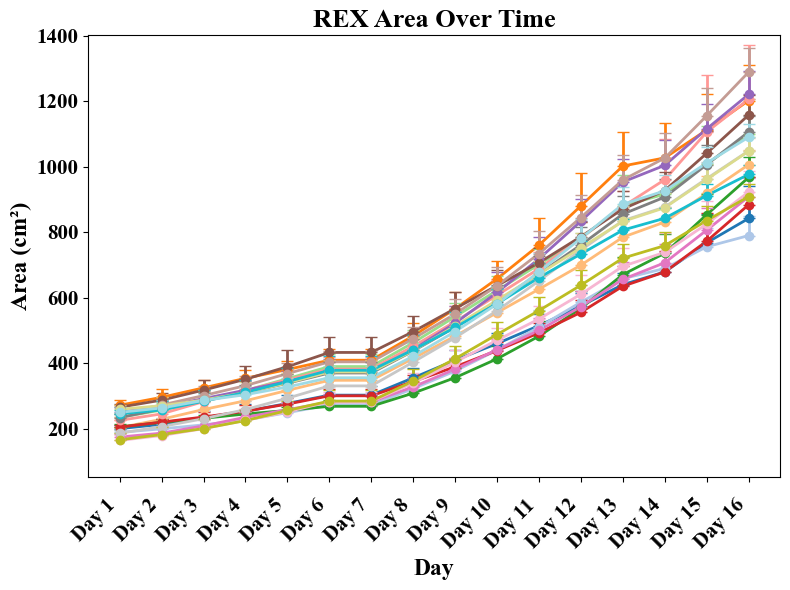

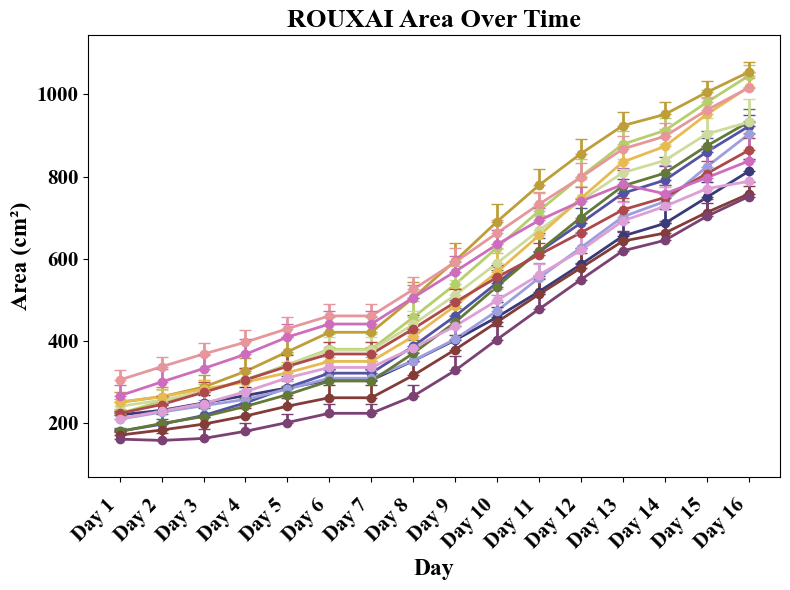

In [77]:
# Set global font family and base size for consistency
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10 

# Read the data from the CSV file
data_area = pd.read_csv("/area_df.csv") # Replace with your file path
data_area['timestamp'] = pd.to_datetime(data_area['timestamp'], format='%Y-%m-%d %H_%M_%S')

data_area.iloc[:, 1:] = data_area.iloc[:, 1:].applymap(lambda x: x if x <= 5000 else None)

first_days = data_area['timestamp'] <= (data_area['timestamp'].min() + pd.Timedelta(days=4))
data_area.loc[first_days, data_area.columns[1:]] = data_area.loc[first_days, data_area.columns[1:]].applymap(
    lambda x: x if x <= 1000 else None
)

data_area.iloc[:, 1:] = data_area.iloc[:, 1:].interpolate(method='linear', limit_direction='both')
df_area = data_area.copy()
for column in data_area.columns[1:]:
    df_area[column] = gaussian_filter1d(data_area[column], sigma=10)

df_area.set_index('timestamp', inplace=True)

# Get a list of all sample columns
sample_columns = [col for col in df_area.columns if col.startswith('area_')]
sample_columns = [col for col in sample_columns if col not in [ 'area_0','area_4', 'area_5', 'area_28', 'area_34', 'area_36', 'area_38']]

# Split the sample columns into two groups of columns
columns_group1 = sample_columns[:19]
columns_group2 = sample_columns[19:]

# ============================
# Plotting Function
# ============================

def process_and_plot(ax, columns_group, group_name, cmap_name='tab20'):
    
    # Create a colormap with a distinct color for each column
    cmap = plt.get_cmap(cmap_name, len(columns_group))
    colors = [cmap(i) for i in range(len(columns_group))]
    all_means = []

    for idx, sample_column in enumerate(columns_group):
        color = colors[idx]
        lower_bound = df_area[sample_column].quantile(0.01)
        upper_bound = df_area[sample_column].quantile(0.99)
        filtered_df = df_area[(df_area[sample_column] >= lower_bound) & (df_area[sample_column] <= upper_bound)]
        daily_mean = filtered_df[sample_column].resample('D').mean()
        daily_max = filtered_df[sample_column].resample('D').max()
        rolling_mean = daily_mean.rolling(window=7, min_periods=1).mean()
        rolling_max = daily_max.rolling(window=7, min_periods=1).mean()
        rolling_max_clipped = np.minimum(rolling_max, rolling_mean * 1.5)
        error_up = rolling_max_clipped - rolling_mean
        all_means.extend(rolling_mean.values)
        day_number = np.arange(1, len(rolling_mean) + 1)
        ax.plot(day_number, rolling_mean.values, label=f'{sample_column} Mean', color=color, linewidth=2)

        # Add error bars representing the max values
        ax.errorbar(
            day_number, 
            rolling_mean.values,
            yerr=[np.zeros_like(error_up.values), error_up.values],
            fmt='o', 
            ecolor=color, 
            elinewidth=2, 
            capsize=4, 
            alpha=1, 
            color=color
        )
        
    min_mean = np.min(all_means)
    max_mean = np.max(all_means)
    y_range = max_mean - min_mean
    padding = y_range * 0.1 

    ax.set_ylim(min_mean - padding, max_mean + padding)
    ax.set_xlabel('Day', fontsize=17, fontweight='bold')
    ax.set_ylabel('Area (cm²)', fontsize=17, fontweight='bold')
    ax.set_title(f'{group_name}', fontsize=19, fontweight='bold')
    ax.tick_params(axis='x', which='major', labelsize=15, rotation=45, pad=10)
    ax.tick_params(axis='y', which='major', labelsize=15)
    tick_positions = np.arange(1, len(day_number) + 1)
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([f'Day {x}' for x in tick_positions], rotation=45, ha='right', fontsize=15)

    y_tick_labels = ax.get_yticklabels()
    for label in y_tick_labels:
        label.set_fontweight('bold')

    x_tick_labels = ax.get_xticklabels()
    for label in x_tick_labels:
        label.set_fontweight('bold')

    return ax

# ============================
# Creating Plots
# ============================

def create_figure(columns_group, group_name, cmap_name, save_path):
    fig, ax = plt.subplots(figsize=(8, 6)) 
    process_and_plot(ax, columns_group, group_name, cmap_name)
    plt.tight_layout()
    fig.savefig(save_path, format='png', dpi=600)
    plt.show()



# Create and display the first figure for Group 1
create_figure(
    columns_group=columns_group1,
    group_name='REX Area Over Time',
    cmap_name='tab20',
    save_path='rex_area_growth_plot.png'
)

# Create and display the second figure for Group 2
create_figure(
    columns_group=columns_group2,
    group_name='ROUXAI Area Over Time',
    cmap_name='tab20b',
    save_path='rouxai_area_growth_plot.png'
)

## Volume growth curve

C:\Users\akash\AppData\Local\Temp\ipykernel_11104\785203526.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned_data_volume.iloc[:, 2:] = cleaned_data_volume.iloc[:, 2:].applymap(lambda x: x if x <= 5000 else None)
C:\Users\akash\AppData\Local\Temp\ipykernel_11104\785203526.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ].applymap(lambda x: x if x <= 2000 else None)


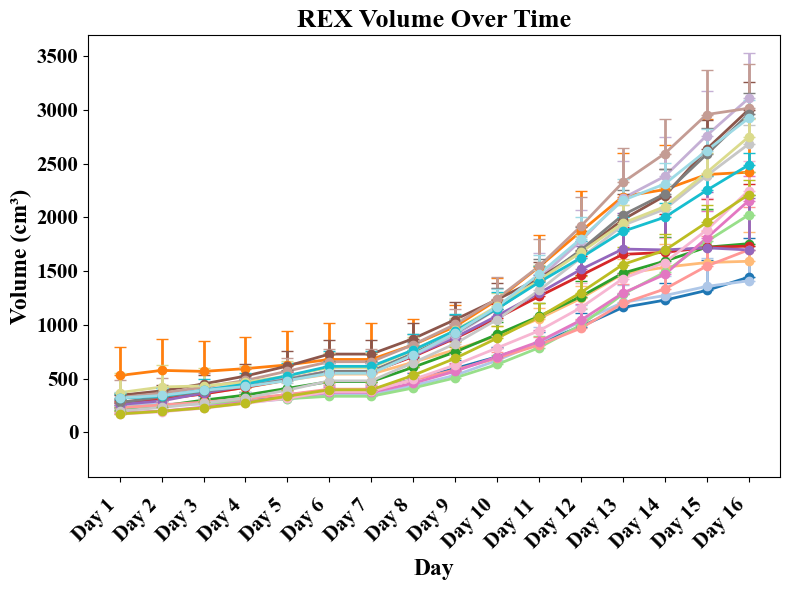

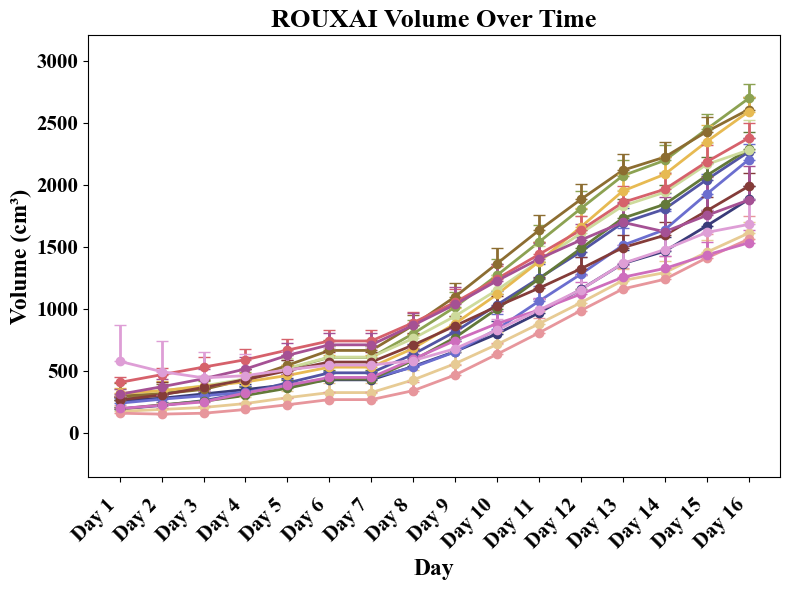

In [75]:
# Set global font family and base size for consistency
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10

# Read the data 
data_volume = pd.read_csv("/volume_df.csv") # Replace with your file path

data_volume['timestamp'] = pd.to_datetime(data_volume['timestamp'], format='%Y-%m-%d %H_%M_%S')
cleaned_data_volume = data_volume.copy()
cleaned_data_volume.iloc[:, 2:] = cleaned_data_volume.iloc[:, 2:].applymap(lambda x: x if x <= 5000 else None)

initial_days_threshold = cleaned_data_volume['timestamp'].iloc[0] + pd.Timedelta(days=4)
initial_days_mask = cleaned_data_volume['timestamp'] <= initial_days_threshold
cleaned_data_volume.loc[initial_days_mask, cleaned_data_volume.columns[2:]] = cleaned_data_volume.loc[
    initial_days_mask, cleaned_data_volume.columns[2:]
].applymap(lambda x: x if x <= 2000 else None)
cleaned_data_volume.iloc[:, 2:] = cleaned_data_volume.iloc[:, 2:].fillna(cleaned_data_volume.iloc[:, 2:].mean())

df_volume = cleaned_data_volume.iloc[:, 2:].apply(lambda col: gaussian_filter1d(col, sigma=5))
df_volume = pd.concat([
    cleaned_data_volume['timestamp'], df_volume
], axis=1)

df_volume.set_index('timestamp', inplace=True)

# Get a list of all sample columns
sample_columns = [col for col in df_volume.columns if col.startswith('volume_')]
sample_columns = [col for col in sample_columns if col not in [ 'volume_0', 'volume_4','volume_28', 'volume_34', 'volume_36']]

# Split the sample columns into two groups of 20 columns each
columns_group1 = sample_columns[:20]
columns_group2 = sample_columns[20:40]

# ============================
# Plotting Function
# ============================

def process_and_plot(ax, columns_group, group_name, cmap_name='tab20'):
    cmap = plt.get_cmap(cmap_name, len(columns_group))
    colors = [cmap(i) for i in range(len(columns_group))]
    all_means = []

    for idx, sample_column in enumerate(columns_group):
        color = colors[idx]
        lower_bound = df_volume[sample_column].quantile(0.01)
        upper_bound = df_volume[sample_column].quantile(0.99)
        filtered_df = df_volume[(df_volume[sample_column] >= lower_bound) & (df_volume[sample_column] <= upper_bound)]
        daily_mean = filtered_df[sample_column].resample('D').mean()
        daily_max = filtered_df[sample_column].resample('D').max()
        rolling_mean = daily_mean.rolling(window=7, min_periods=1).mean()
        rolling_max = daily_max.rolling(window=7, min_periods=1).mean()
        rolling_max_clipped = np.minimum(rolling_max, rolling_mean * 1.5)
        error_up = rolling_max_clipped - rolling_mean
        all_means.extend(rolling_mean.values)
        day_number = np.arange(1, len(rolling_mean) + 1)
        ax.plot(day_number, rolling_mean.values, label=f'{sample_column} Mean', color=color, linewidth=2)

        # Add error bars representing the max values
        ax.errorbar(
            day_number, 
            rolling_mean.values,
            yerr=[np.zeros_like(error_up.values), error_up.values],
            fmt='o', 
            ecolor=color, 
            elinewidth=2, 
            capsize=4, 
            alpha=1, 
            color=color
        )

    min_mean = np.min(all_means)
    max_mean = np.max(all_means)
    y_range = max_mean - min_mean
    padding = y_range * 0.2

    ax.set_ylim(min_mean - padding, max_mean + padding)
    ax.set_xlabel('Day', fontsize=17, fontweight='bold')
    ax.set_ylabel('Volume (cm³)', fontsize=17, fontweight='bold')
    ax.set_title(f'{group_name}', fontsize=19, fontweight='bold')
    ax.tick_params(axis='x', which='major', labelsize=15, rotation=45, pad=10)
    ax.tick_params(axis='y', which='major', labelsize=15)
    tick_positions = np.arange(1, len(day_number) + 1)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([f'Day {x}' for x in tick_positions], rotation=45, ha='right', fontsize=15)

    y_tick_labels = ax.get_yticklabels()
    for label in y_tick_labels:
        label.set_fontweight('bold')
        
    x_tick_labels = ax.get_xticklabels()
    for label in x_tick_labels:
        label.set_fontweight('bold')

    return ax


# ============================
# Creating Plots
# ============================

def create_figure(columns_group, group_name, cmap_name, save_path):
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjusted figsize for better visibility
    process_and_plot(ax, columns_group, group_name, cmap_name)
    plt.tight_layout()
    fig.savefig(save_path, format='png', dpi=600)
    plt.show()


# Create and display the first figure for Group 1
create_figure(
    columns_group=columns_group1,
    group_name='REX Volume Over Time',
    cmap_name='tab20',
    save_path='rex_volume_growth_plot.png'
)

# Create and display the second figure for Group 2
create_figure(
    columns_group=columns_group2,
    group_name='ROUXAI Volume Over Time',
    cmap_name='tab20b',
    save_path='rouxai_volume_growth_plot.png'
)